# 1. Install Dependencies and Setup

# 2. Remove Dodgy Images

# 3. Load Data

In [2]:
import os
import cv2
import numpy as np

In [3]:
data_dir = 'SKC'  # Path to your dataset directory
categories = ['basal cell carcinoma', 'melanoma', 'squamous cell carcinoma']  # Categories or class labels


In [4]:
images = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, (224, 224))  # Resize the image to a desired size
        images.append(img)
        labels.append(categories.index(category))

# Convert the lists to numpy arrays
images = np.array(images)
labels = np.array(labels)


# 4. Scale Data


In [5]:
images = images / 255.0

# 5. Split Data

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)


# 6. Build Deep Learning Model

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(categories), activation='softmax')
])


# 7. Train

In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/20
27/27 [==============================] - 116s 4s/step - loss: 2.3642 - accuracy: 0.4952 - val_loss: 1.4151 - val_accuracy: 0.4258
Epoch 2/20
27/27 [==============================] - 86s 3s/step - loss: 0.9205 - accuracy: 0.5959 - val_loss: 0.8008 - val_accuracy: 0.6603
Epoch 3/20
27/27 [==============================] - 97s 4s/step - loss: 0.7824 - accuracy: 0.6739 - val_loss: 1.3916 - val_accuracy: 0.4211
Epoch 4/20
27/27 [==============================] - 98s 4s/step - loss: 0.9656 - accuracy: 0.6103 - val_loss: 0.8546 - val_accuracy: 0.6172
Epoch 5/20
27/27 [==============================] - 101s 4s/step - loss: 0.8861 - accuracy: 0.6175 - val_loss: 1.0572 - val_accuracy: 0.4067
Epoch 6/20
27/27 [==============================] - 104s 4s/step - loss: 0.8228 - accuracy: 0.6619 - val_loss: 0.7416 - val_accuracy: 0.6938
Epoch 7/20
27/27 [==============================] - 105s 4s/step - loss: 0.5935 - accuracy: 0.7530 - val_loss: 0.8778 - val_accuracy: 0.6029
Epoch 8/20
27/27

# 8. Plot Performance

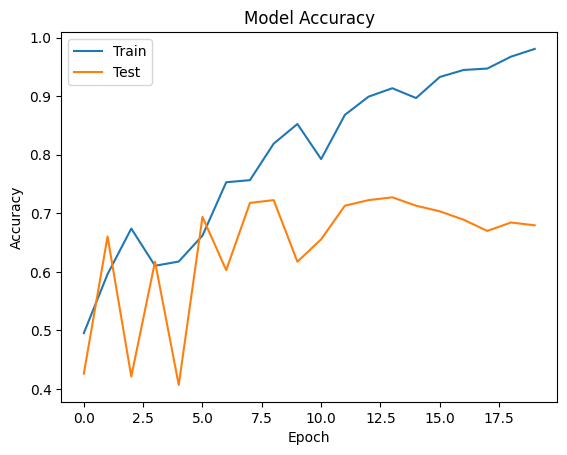

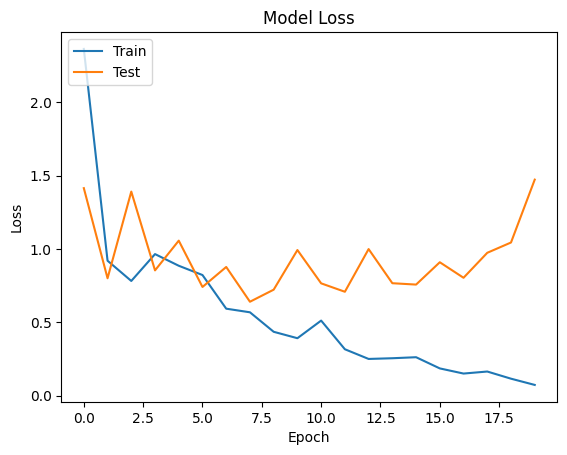

In [9]:
import matplotlib.pyplot as plt

history = model.history.history

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 9. Evaluate

In [10]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

7/7 [==============================] - 10s 1s/step - loss: 1.4731 - accuracy: 0.6794
Test Loss: 1.4731205701828003
Test Accuracy: 0.679425835609436


# 10. Test

In [11]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('models/imageclassifier.h5')

# Load and preprocess the image
image_path = 'SKC/melanoma/ISIC_0000004.jpg'  # Replace with the path to your image
image = cv2.imread(image_path)
image = cv2.resize(image, (256, 256))
image = image.astype('float32') / 255.0
image = np.expand_dims(image, axis=0)

# Perform prediction
prediction = model.predict(image)
predicted_class = np.argmax(prediction)

# Get the class label
class_labels = ['Basal Cell Carcinoma', 'Melanoma', 'Squamous cell carcinoma']  # Update with your class labels
predicted_label = class_labels[predicted_class]

# Display the predicted label
print('Predicted label:', predicted_label)

1/1 [==============================] - 0s 353ms/step
Predicted label: Basal Cell Carcinoma


# 11. Save the Model

In [12]:
model.save('skin_cancer_model.h5')

# 12. Connect the User Interface

In [13]:
import os
from flask import Flask, render_template, request
from werkzeug.utils import secure_filename
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Initialize Flask application
app = Flask(__name__)

# Load the skin cancer classifier model
model = load_model('skin_cancer_model.h5')
categories = ['basall cell carcinoma', 'melanoma', 'squamous cell carcinoma']

# Define allowed file extensions
ALLOWED_EXTENSIONS = {'jpg', 'jpeg', 'png'}

# Configure upload folder
UPLOAD_FOLDER = 'uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER


def allowed_file(filename):
    # Check if the file has an allowed extension
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS


def preprocess_image(image):
    # Preprocess the image for prediction
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))  # Adjust the size according to the model requirements
    image = image.astype('float32') / 255.0
    return image


def classify_image(image):
    # Classify the image using the loaded model
    preprocessed_image = preprocess_image(image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    prediction = model.predict(preprocessed_image)
    predicted_label = categories[np.argmax(prediction)]
    return predicted_label


@app.route('/')
def index():
    # Render the index.html template
    return render_template('index.html')


@app.route('/upload', methods=['POST'])
def upload():
    # Handle file upload from the front-end
    if 'file' not in request.files:
        return 'No file uploaded', 400

    file = request.files['file']

    if file.filename == '':
        return 'No selected file', 400

    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(filepath)

        # Load and classify the uploaded image
        image = cv2.imread(filepath)
        predicted_label = classify_image(image)

        # Remove the uploaded file
        os.remove(filepath)

        return f'Predicted label: {predicted_label}'

    return 'Invalid file', 400


if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [28/May/2023 16:43:20] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 318ms/step


127.0.0.1 - - [28/May/2023 16:43:36] "POST /upload HTTP/1.1" 200 -


1/1 [==============================] - 0s 89ms/step


127.0.0.1 - - [28/May/2023 16:45:24] "POST /upload HTTP/1.1" 200 -
